### Definición experimentación 1ª Iteración

**En esta iteración se utilizará tal cual el entorno de OpenAI gymAnytrading, sin realizarle ninguna modificación**.

**Series a predecir**: todos los pares de divisas

**Longitud entrenamiento**: 2 años.

**Longitud test**: 6 meses.

**window_size**: Fijo o variable. Creo que fijo a 50 días es lo que renta. Fijo a 50 días.

**Medición del mejor modelo**: el que en el conjunto de test saque el mejor sharpe ratio.

**Entre qué se elige**: distintos modelos y distintas políticas para cada modelo. Combinamos estos y sacamos la mejor combinación para cada par de divisas.

In [39]:
import numpy as np
import pandas as pd

import gym
import gym_anytrading
import quantstats as qs

from stable_baselines import A2C
from stable_baselines import DQN
from stable_baselines.common.vec_env import DummyVecEnv

import matplotlib.pyplot as plt

In [40]:
AUDUSD = pd.read_csv('../../Datasets/AUDUSD_Candlestick_1_Hour_BID_01.01.2007-25.12.2021.csv')
EURUSD = pd.read_csv('../../Datasets/EURUSD_Candlestick_1_Hour_BID_01.01.2007-25.12.2021.csv')
GBPUSD = pd.read_csv('../../Datasets/GBPUSD_Candlestick_1_Hour_BID_01.01.2007-25.12.2021.csv')
NZDUSD = pd.read_csv('../../Datasets/NZDUSD_Candlestick_1_Hour_BID_01.01.2007-25.12.2021.csv')
USDCAD = pd.read_csv('../../Datasets/USDCAD_Candlestick_1_Hour_BID_01.01.2007-25.12.2021.csv')
USDCHF = pd.read_csv('../../Datasets/USDCHF_Candlestick_1_Hour_BID_01.01.2007-25.12.2021.csv')
USDJPY = pd.read_csv('../../Datasets/USDJPY_Candlestick_1_Hour_BID_01.01.2007-25.12.2021.csv')

In [41]:
import seaborn as sns
from finta import TA

In [42]:
# 1. Limpiamos el dataset ya que las fechas como vienen están mal
# 2. Asignamos el conjunto de entrenamiento y test de cada par de divisas. 
# El train va desde Junio 2019 a Junio 2021 y el test de Junio 2021 a Diciembre 2021

df_pair = {}
df_pair['AUDUSD'] = AUDUSD
df_pair['EURUSD'] = EURUSD
df_pair['GBPUSD'] = GBPUSD
df_pair['NZDUSD'] = NZDUSD
df_pair['USDCAD'] = USDCAD
df_pair['USDCHF'] = USDCHF
df_pair['USDJPY'] = USDJPY
df_train = {}
df_test = {}
names = list(df_pair.keys())
for i in range(len(df_pair)):
    df = df_pair[names[i]]
    df = df.drop(df[df.Volume == 0].index)
    df = df.rename(columns={'Gmt time': 'Date'})
    #AUDUSD['Date'] =  pd.to_times(AUDUSD['Date'])
    #AUDUSD.set_index('Date', inplace=True)

    df['Day'] = df['Date'].astype(str).str[0:2]
    df['Month'] = df['Date'].astype(str).str[3:5]
    df['Year'] = df['Date'].astype(str).str[6:10]
    df['Hour'] = df['Date'].astype(str).str[11:13]
    df['Date'] = pd.to_datetime(df[['Day', 'Month', 'Year', 'Hour']])
    df.set_index('Date', inplace=True)
    df = df[["Open","High","Low","Close","Volume"]]
    
    df['SMA'] = TA.SMA(df, 12)
    df['RSI'] = TA.RSI(df)
    df['OBV'] = TA.OBV(df)
    df.fillna(0, inplace=True)
    
    
    df_pair[names[i]] = df
    # Train
    df_train[names[i]] = df_pair[names[i]].query("20190630 < index < 20210701")
    # Test
    df_test[names[i]] = df_pair[names[i]].query("20210701 < index < 20211226")

<AxesSubplot:>

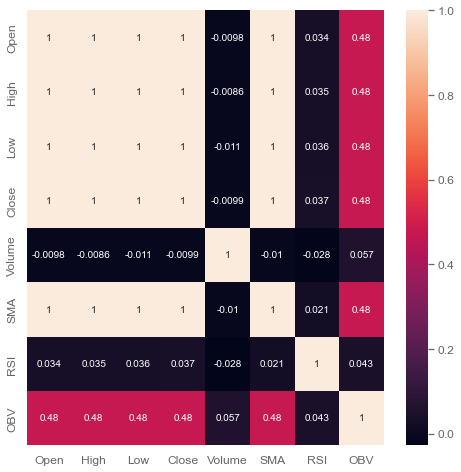

In [43]:
fig, ax = plt.subplots(figsize=(8,8))
cormat = df_pair['AUDUSD'].corr()
round(cormat,2)
sns.heatmap(cormat,annot=True)
# No podemos meter como variables de entrada Close Low High y Open, se tendrá que meter 1

In [44]:
window_size_1 = 50
start_index = window_size_1
end_index = len(df_train[names[0]])
frame_bound = (start_index, end_index)

#desired_total_episodes = 75
desired_total_episodes = 50
n_points = end_index - start_index
# get the number of timesteps
total_timesteps = desired_total_episodes*n_points

In [45]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Low', 'Volume','SMA', 'RSI', 'OBV']].to_numpy()[start:end]
    return prices, signal_features

In [46]:
# Defining functions

In [47]:
from gym_anytrading.envs import ForexEnv

In [48]:
def model_train_test(df_train,df_test, algo, policy):
    class MyCustomEnv(ForexEnv):
        _process_data = add_signals
    
    env2 = MyCustomEnv(df = df_train,window_size = window_size_1, frame_bound = (window_size_1, len(df_train)))    
    env_maker = lambda: env2
    env = DummyVecEnv([env_maker])
    model = algo(policy, env)
    #model = algo(policy, env, verbose=1)
    model.learn(total_timesteps=total_timesteps)
    
    # Test
    env = MyCustomEnv(df = df_test, window_size = window_size_1, frame_bound = (window_size_1, len(df_test))) 
   # env = gym.make('forex-v0', df=df_test, frame_bound=(window_size_1, len(df_test)), window_size=window_size_1)
    obs = env.reset()
    while True: 
        obs = obs[np.newaxis, ...]
        action, _states = model.predict(obs)
        obs, rewards, done, info = env.step(action)
        if done:
            print("info", info)
            break
    start_index = window_size_1
    end_index = len(df_test)
    qs.extend_pandas()
    net_worth = pd.Series(env.history['total_profit'], index=df_test.index[start_index+1:end_index])
    returns = net_worth.pct_change().iloc[1:]
    return(returns)

### Results A2C

In [49]:
# RESULTS A2C
# Hora comienzo: 13:30
results = {} 
policy_A2C = ['MlpPolicy','MlpLstmPolicy','MlpLnLstmPolicy']
# Create dictionary with each pair
for i in range(len(df_train)):
    results[str(names[i])] = {}

for i in range(len(df_train)):
    for j in range(len(policy_A2C)):
        results[str(names[i])]['A2C_'+str(policy_A2C[j])] = model_train_test(df_train[names[i]],df_test[names[i]], A2C, policy_A2C[j])

info {'total_reward': 90.70000000002129, 'total_profit': 0.9475356039019875, 'position': 0}
info {'total_reward': 412.100000000004, 'total_profit': 1.0242810835908125, 'position': 0}
info {'total_reward': 309.60000000000434, 'total_profit': 1.0186853050150468, 'position': 0}
info {'total_reward': -670.4999999999501, 'total_profit': 0.8216399630094515, 'position': 0}
info {'total_reward': 583.6999999999891, 'total_profit': 1.0457467590923601, 'position': 0}
info {'total_reward': -598.000000000034, 'total_profit': 0.9151508105620129, 'position': 1}
info {'total_reward': 199.90000000001945, 'total_profit': 0.9661173356680913, 'position': 0}
info {'total_reward': 475.3000000000005, 'total_profit': 1.0282831996460362, 'position': 0}
info {'total_reward': 653.4999999998936, 'total_profit': 0.9227739288391439, 'position': 0}
info {'total_reward': -1.2720491326945194e-11, 'total_profit': 0.8618556525308008, 'position': 1}
info {'total_reward': 299.7999999999979, 'total_profit': 1.0040534791538

In [53]:
import pickle

In [54]:
# Para guardar los resultados
try:
    geeky_file = open('A2C_iter_2', 'wb')
    pickle.dump(results, geeky_file)
    geeky_file.close()
  
except:
    print("Something went wrong")

In [56]:
with open('A2C_iter_2', 'rb') as f:
    A2C_iter_2 = pickle.load(f)

In [57]:
A2C_iter_2

{'AUDUSD': {'A2C_MlpPolicy': Date
  2021-07-05 05:00:00    0.000000
  2021-07-05 06:00:00    0.000000
  2021-07-05 07:00:00    0.000000
  2021-07-05 08:00:00    0.000000
  2021-07-05 09:00:00    0.000000
                           ...   
  2021-12-24 17:00:00    0.000000
  2021-12-24 18:00:00    0.000000
  2021-12-24 19:00:00    0.000000
  2021-12-24 20:00:00    0.000000
  2021-12-24 21:00:00    0.002163
  Length: 2992, dtype: float64,
  'A2C_MlpLstmPolicy': Date
  2021-07-05 05:00:00    0.000000
  2021-07-05 06:00:00    0.000000
  2021-07-05 07:00:00    0.000000
  2021-07-05 08:00:00    0.000000
  2021-07-05 09:00:00    0.000000
                           ...   
  2021-12-24 17:00:00    0.000000
  2021-12-24 18:00:00    0.000000
  2021-12-24 19:00:00    0.000000
  2021-12-24 20:00:00    0.000000
  2021-12-24 21:00:00   -0.002801
  Length: 2992, dtype: float64,
  'A2C_MlpLnLstmPolicy': Date
  2021-07-05 05:00:00    0.000000
  2021-07-05 06:00:00    0.000000
  2021-07-05 07:00:00    0.0

### Results DQN

In [ ]:
# RESULTS DQN
results = {} 
policy_DQN = ['MlpPolicy','LnMlpPolicy']
# Create dictionary with each pair
for i in range(len(df_train)):
    results[str(names[i])] = {}

for i in range(len(df_train)):
    for j in range(len(policy_DQN)):
        results[str(names[i])]['DQN_'+str(policy_DQN[j])] = model_train_test(df_train[names[i]],df_test[names[i]], DQN, policy_DQN[j])

In [ ]:
# Hora de inicio del bucle: 12:44

In [178]:
A2C_iter_1

{'AUDUSD': {'A2C_MlpPolicy': Date
  2021-07-05 05:00:00    0.000000
  2021-07-05 06:00:00    0.000000
  2021-07-05 07:00:00   -0.002696
  2021-07-05 08:00:00    0.000000
  2021-07-05 09:00:00    0.000000
                           ...   
  2021-12-24 17:00:00    0.000000
  2021-12-24 18:00:00    0.000000
  2021-12-24 19:00:00   -0.000747
  2021-12-24 20:00:00    0.000000
  2021-12-24 21:00:00    0.000929
  Length: 2992, dtype: float64,
  'A2C_MlpLstmPolicy': Date
  2021-07-05 05:00:00    0.000000
  2021-07-05 06:00:00    0.000000
  2021-07-05 07:00:00    0.000000
  2021-07-05 08:00:00    0.000000
  2021-07-05 09:00:00    0.000000
                           ...   
  2021-12-24 17:00:00    0.000000
  2021-12-24 18:00:00    0.000000
  2021-12-24 19:00:00    0.000000
  2021-12-24 20:00:00    0.000000
  2021-12-24 21:00:00    0.000804
  Length: 2992, dtype: float64,
  'A2C_MlpLnLstmPolicy': Date
  2021-07-05 05:00:00    0.000359
  2021-07-05 06:00:00    0.000000
  2021-07-05 07:00:00    0.0